*After days of learning about object detectiona and cnns , I spent many days implementing and removing errors . The task invloves multi-class and multi bboxes which can be quite complex to handle the ouput and loss functions. So , I have solved the question for one object per image :)*

IMPORT NECESSARY MODULES

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the dataset
(train_dataset, val_dataset), info = tfds.load('voc/2007', split=['train', 'validation'], with_info=True)

IMG_SIZE = 256
NUM_CLASSES = info.features['objects']['label'].num_classes


**LOAD THE DATASET**
*   We use tensorflow datasets api and tfds.load() which is a thin wrapper around the tfds.build api
*   Train and validation data are loaded along with information about the voc 2007 dataset

**WHY VOC 2007 ?**


*   The voc 2012 is broken in tfds api and also manually downloading it is corrupted
*   Coco and open images are huge to perform local computation

The data set contains elements which have a features dictionary defined in the next code cell

**Explanation of revelent features :**

* image : tf.Tensor of type tf.uint8 and shape [height, width, num_channels]

* image/filename : name of the image file

* labels : tf.Tensor of type tf.int64 and shape [presentLabel1,PresentLabel2,....]

* labels_no_difficult : labels which are not difficult to recognize

*objects* : sequence of sub-features
    

*   bbox : tf.Tensor of type tf.float32 and shape [num_of_boxes,4]
*   label : tf.Tensor of type int64 and shape  
[
presentLabel1_1,presentLabel1_2,.....
presentLabel2_1,presentLabel2_2....
]



In [2]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'labels': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=20)),
    'labels_no_difficult': Sequence(ClassLabel(shape=(), dtype=int64, num_classes=20)),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'is_difficult': bool,
        'is_truncated': bool,
        'label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'pose': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
})

**DATA EXPLORATION**

  plot the image and bboxes using matplotlib

   ERROR:
   
   Since the bbox coordinates are already normalised , I needed to denormalize them and extract width height from it


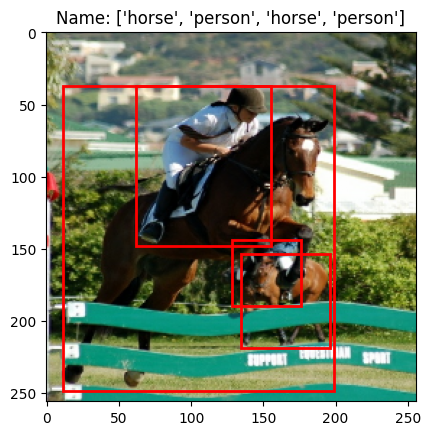

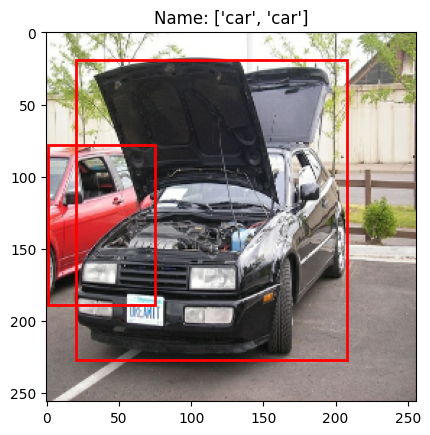

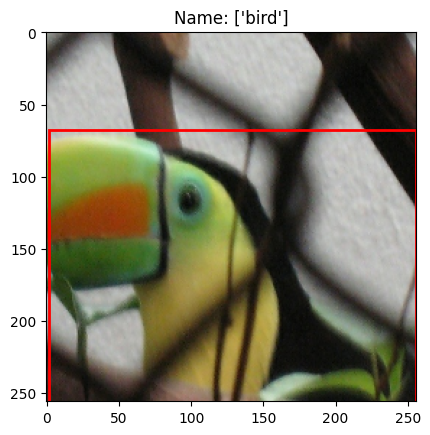

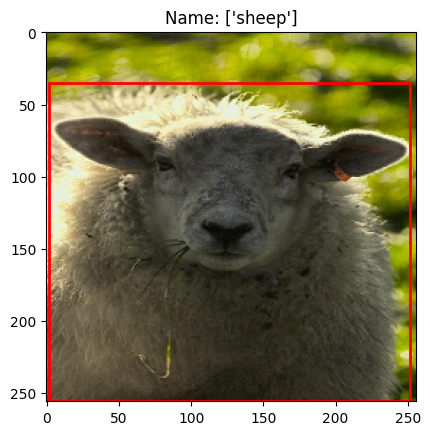

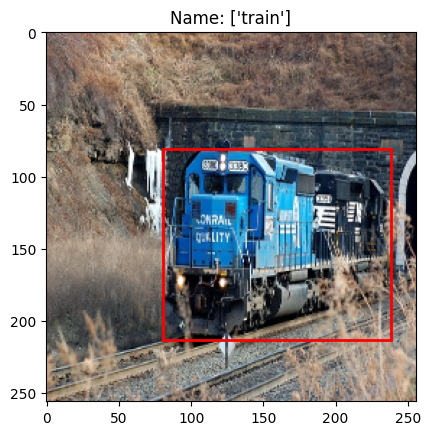

In [3]:
def plot_image_with_bboxes(example):
    image = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE)) / 255.0
    labels = example['objects']['label']
    bboxes = example['objects']['bbox']
    class_names = info.features['objects']['label'].names
    label_names=[class_names[lbl] for lbl in labels]
    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.set_title(f'Name: {label_names}')
    # Add bounding boxes to the image
    for bbox in bboxes:
        # Bounding box coordinates are normalized (0,1)
        ymin, xmin, ymax, xmax = bbox
        x = xmin * IMG_SIZE
        y = ymin * IMG_SIZE
        width = (xmax - xmin) * IMG_SIZE
        height = (ymax - ymin) * IMG_SIZE

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

for example in train_dataset.take(5):
    plot_image_with_bboxes(example)

In [4]:
def filter_single_object(data):
    # Filter images that contain exactly one object
    num_objects = tf.shape(data['objects']['label'])[0]
    return num_objects == 1

def preprocess(data):
    image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE)) / 255.0
    label = data['objects']['label'][0]  # Use only the first (and only) label
    return image, label

# Filter dataset to include only images with one object
train_dataset = train_dataset.filter(filter_single_object)
train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.filter(filter_single_object)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)



Defines two functions for preprocessing image data.

 **The filter_single_object function**:

  checks if an image contains exactly one object by counting the number of objects in the image.
  
  **The preprocess function**:
  
   resizes the image and extracts the label of the single object present, preparing the data for further processing

In [5]:
from tensorflow.keras.regularizers import l2

def build_model_with_l2(num_classes):
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)

    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_output')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=class_output)
    return model

model = build_model_with_l2(NUM_CLASSES)

The model structure is given below as an image also defined here :

1.  **Input Layer**:

  Defines the input layer with the shape (IMG_SIZE, IMG_SIZE, 3),
  where IMG_SIZE is the size of the resized images (128 in this case) and 3 corresponds to the RGB color channels.

2.  **Convolutional and Pooling Layers:**

  * *First Convolutional Layer*:
  
  Applies 32 filters of size (3, 3) with ReLU activation, followed by a max-pooling layer that downsamples the feature maps by a factor of 2.
  * *Second Convolutional Layer*:
  
   Applies 64 filters of size (3, 3) with ReLU activation, followed by a max-pooling layer that downsamples the feature maps by a factor of 2.
  * *Third Convolutional Layer*:
  
  Applies 128 filters of size (3, 3) with ReLU activation, followed by a max-pooling layer that downsamples the feature maps by a factor of 2.

  These layers help in extracting hierarchical features from the images, capturing spatial hierarchies.

3.  **Flatten Layer:**

  Flattens the 3D tensor output from the last convolutional layer into a 1D tensor, preparing it for the fully connected (dense) layer.

4.  **Dense Layer:**

  A fully connected layer with 256 units and ReLU activation. This layer combines all the features extracted by the convolutional layers and prepares them for the final output layers.

5.  **Class Output:**

  Dense Layer for Class Output: This layer has num_classes units with softmax activation. It predicts the class probabilities of the object in the image.
  Naming: The layer is named 'class_output' to identify it clearly when using loss functions and metrics.


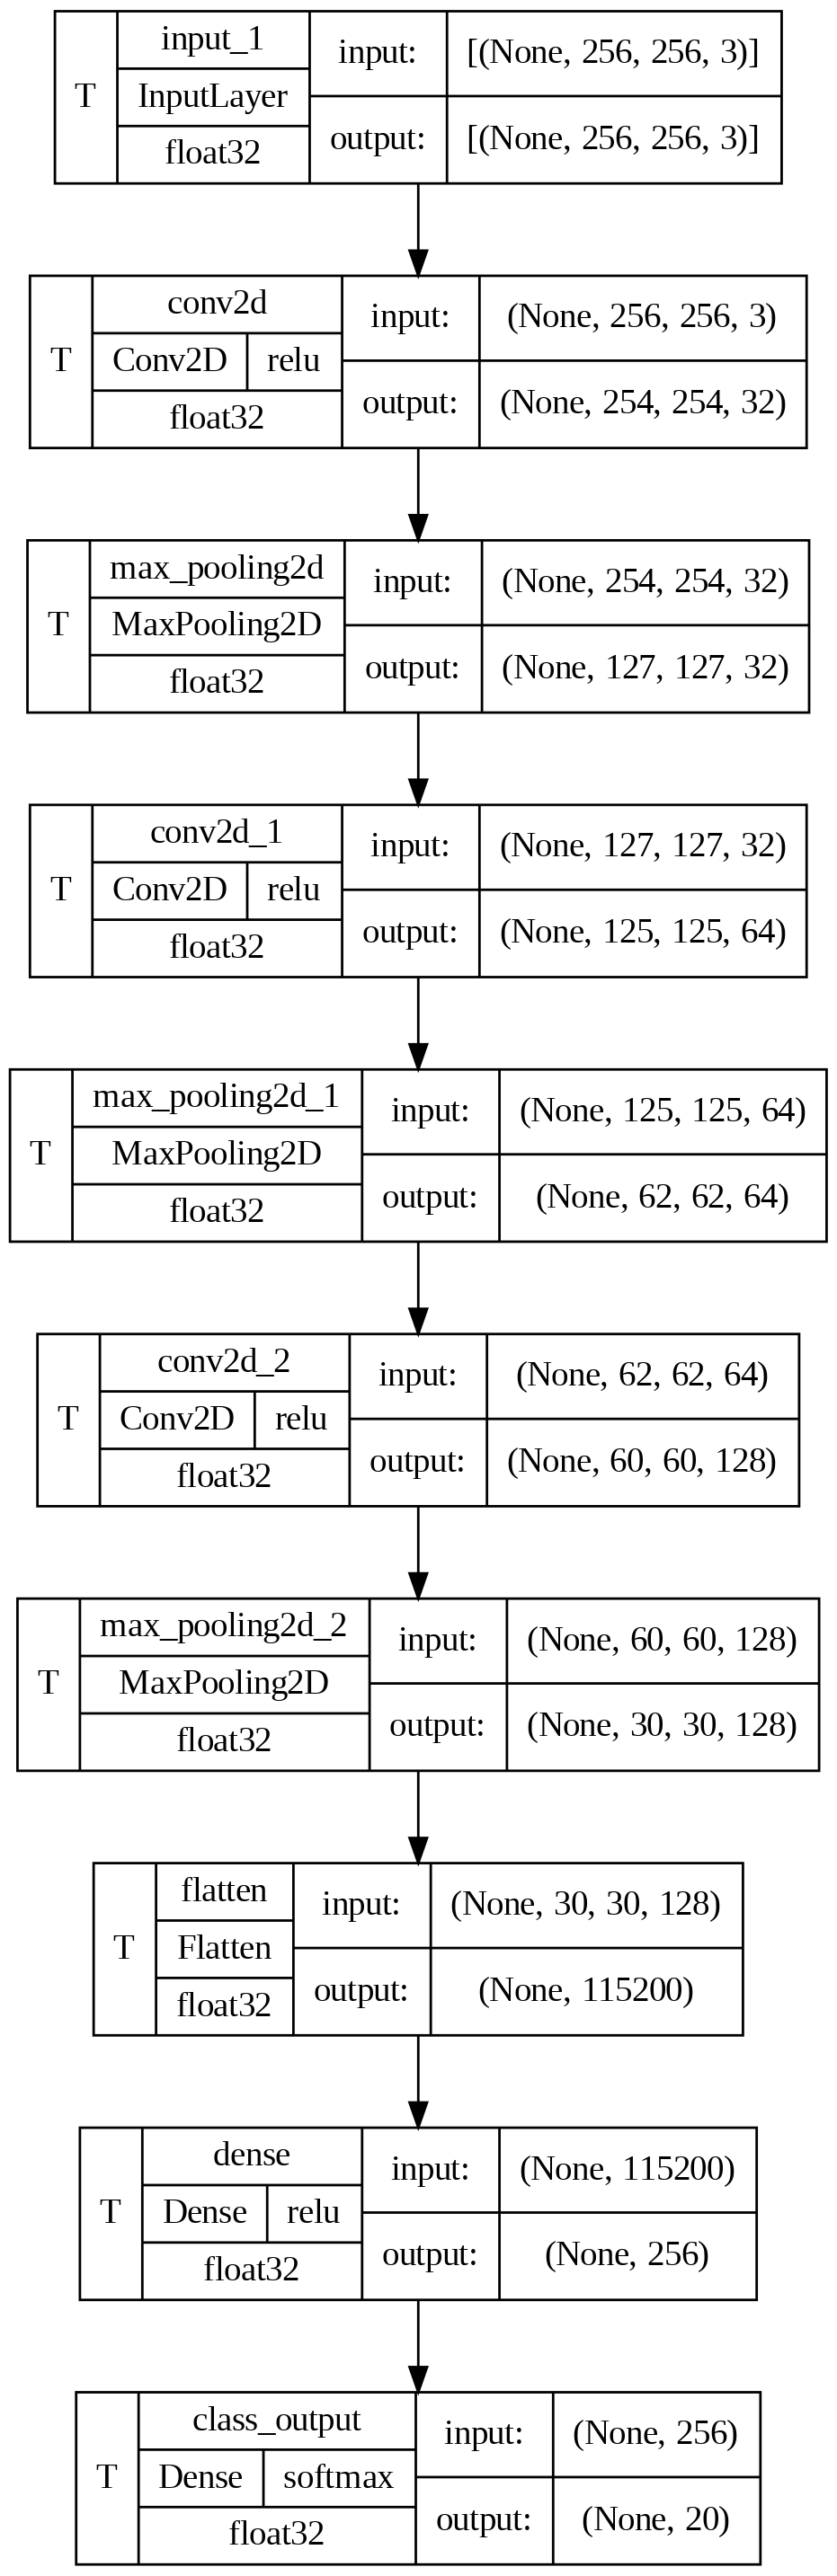

In [6]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

Use Sparse Categorical Crossentropy because of more than 2 labels are present

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/50
29/29 [==============================] - 16s 367ms/step - loss: 3.7914 - accuracy: 0.1337 - val_loss: 3.3855 - val_accuracy: 0.1031
Epoch 2/50
29/29 [==============================] - 10s 344ms/step - loss: 3.0525 - accuracy: 0.1901 - val_loss: 2.9897 - val_accuracy: 0.1552
Epoch 3/50
29/29 [==============================] - 11s 374ms/step - loss: 2.7890 - accuracy: 0.2486 - val_loss: 2.8865 - val_accuracy: 0.1990
Epoch 4/50
29/29 [==============================] - 9s 325ms/step - loss: 2.5783 - accuracy: 0.2917 - val_loss: 2.7507 - val_accuracy: 0.2302
Epoch 5/50
29/29 [==============================] - 10s 366ms/step - loss: 2.2865 - accuracy: 0.3790 - val_loss: 2.7778 - val_accuracy: 0.2510
Epoch 6/50
29/29 [==============================] - 10s 354ms/step - loss: 1.9070 - accuracy: 0.5006 - val_loss: 2.9891 - val_accuracy: 0.2500
Epoch 7/50
29/29 [==============================] - 9s 319ms/step - loss: 1.3991 - accuracy: 0.6796 - val_loss: 3.8502 - val_accuracy: 0.2010
E

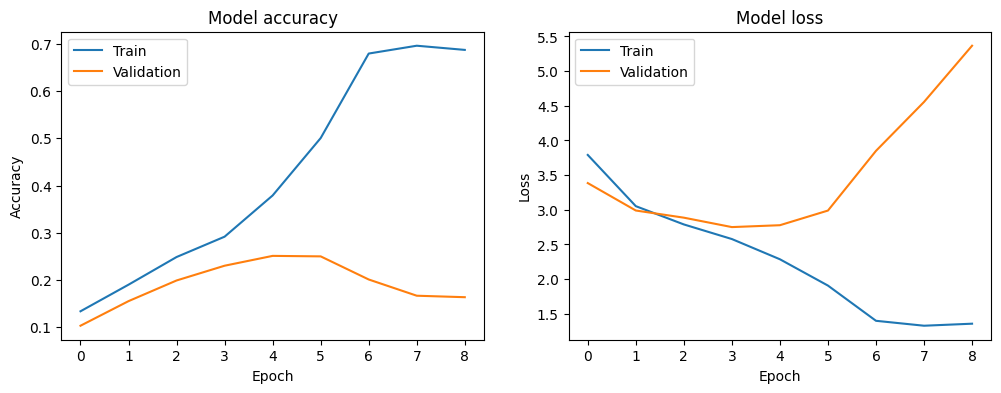

In [8]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history)

1. **Load the test dataset:**
- `tfds.load('voc/2007', split='test', with_info=True)`: This line loads the VOC 2007 dataset, specifically the "test" split. It also retrieves information about the dataset using `with_info=True`.

2. **Filter and preprocess:**
- `test_dataset.filter(filter_single_object)`: This line applies a custom function `filter_single_object` to the dataset. This function likely filters out samples that don't meet certain criteria (e.g., only include samples with a single object).
- `test_dataset.map(preprocess)`: This applies another custom function `preprocess` to each sample in the dataset. This function likely performs necessary preprocessing steps like resizing images, converting data types, etc., to prepare the data for the model.
- `.batch(32)`: This groups samples into batches of 32 for efficient processing.
- `.prefetch(tf.data.experimental.AUTOTUNE)`: This prefetches data to speed up the evaluation process.

3. **Evaluate the model:**
- `model.evaluate(test_dataset)`: This runs the model on the preprocessed test dataset and returns the test loss and accuracy.
- `print(f'Test Accuracy: {test_accuracy:.2f}')`: This prints the calculated test accuracy to two decimal places.

In [11]:
# Load the test dataset
test_dataset, test_info = tfds.load('voc/2007', split='test', with_info=True)

# Filter and preprocess the test dataset
test_dataset = test_dataset.filter(filter_single_object)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy:.2f}')

60/60 [==============================] - 10s 154ms/step - loss: 2.7258 - accuracy: 0.2315
Test Accuracy: 0.23


In [14]:
from sklearn.metrics import precision_score, recall_score

# Get ground truth labels and predictions
y_true = []
y_pred = []
y_scores = []

for image, label in test_dataset:
    y_true.extend(label.numpy())
    predictions = model.predict(image)
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())
    y_scores.extend(predictions)  # Store raw prediction scores for mAP calculation

# Calculate precision, recall, and mean average precision
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


1/1 [==============================] - 0s 61ms/step
Precision: 0.24
Recall: 0.23


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
model.save('voc2007_single_object_model.keras')

1/1 [==============================] - 0s 36ms/step


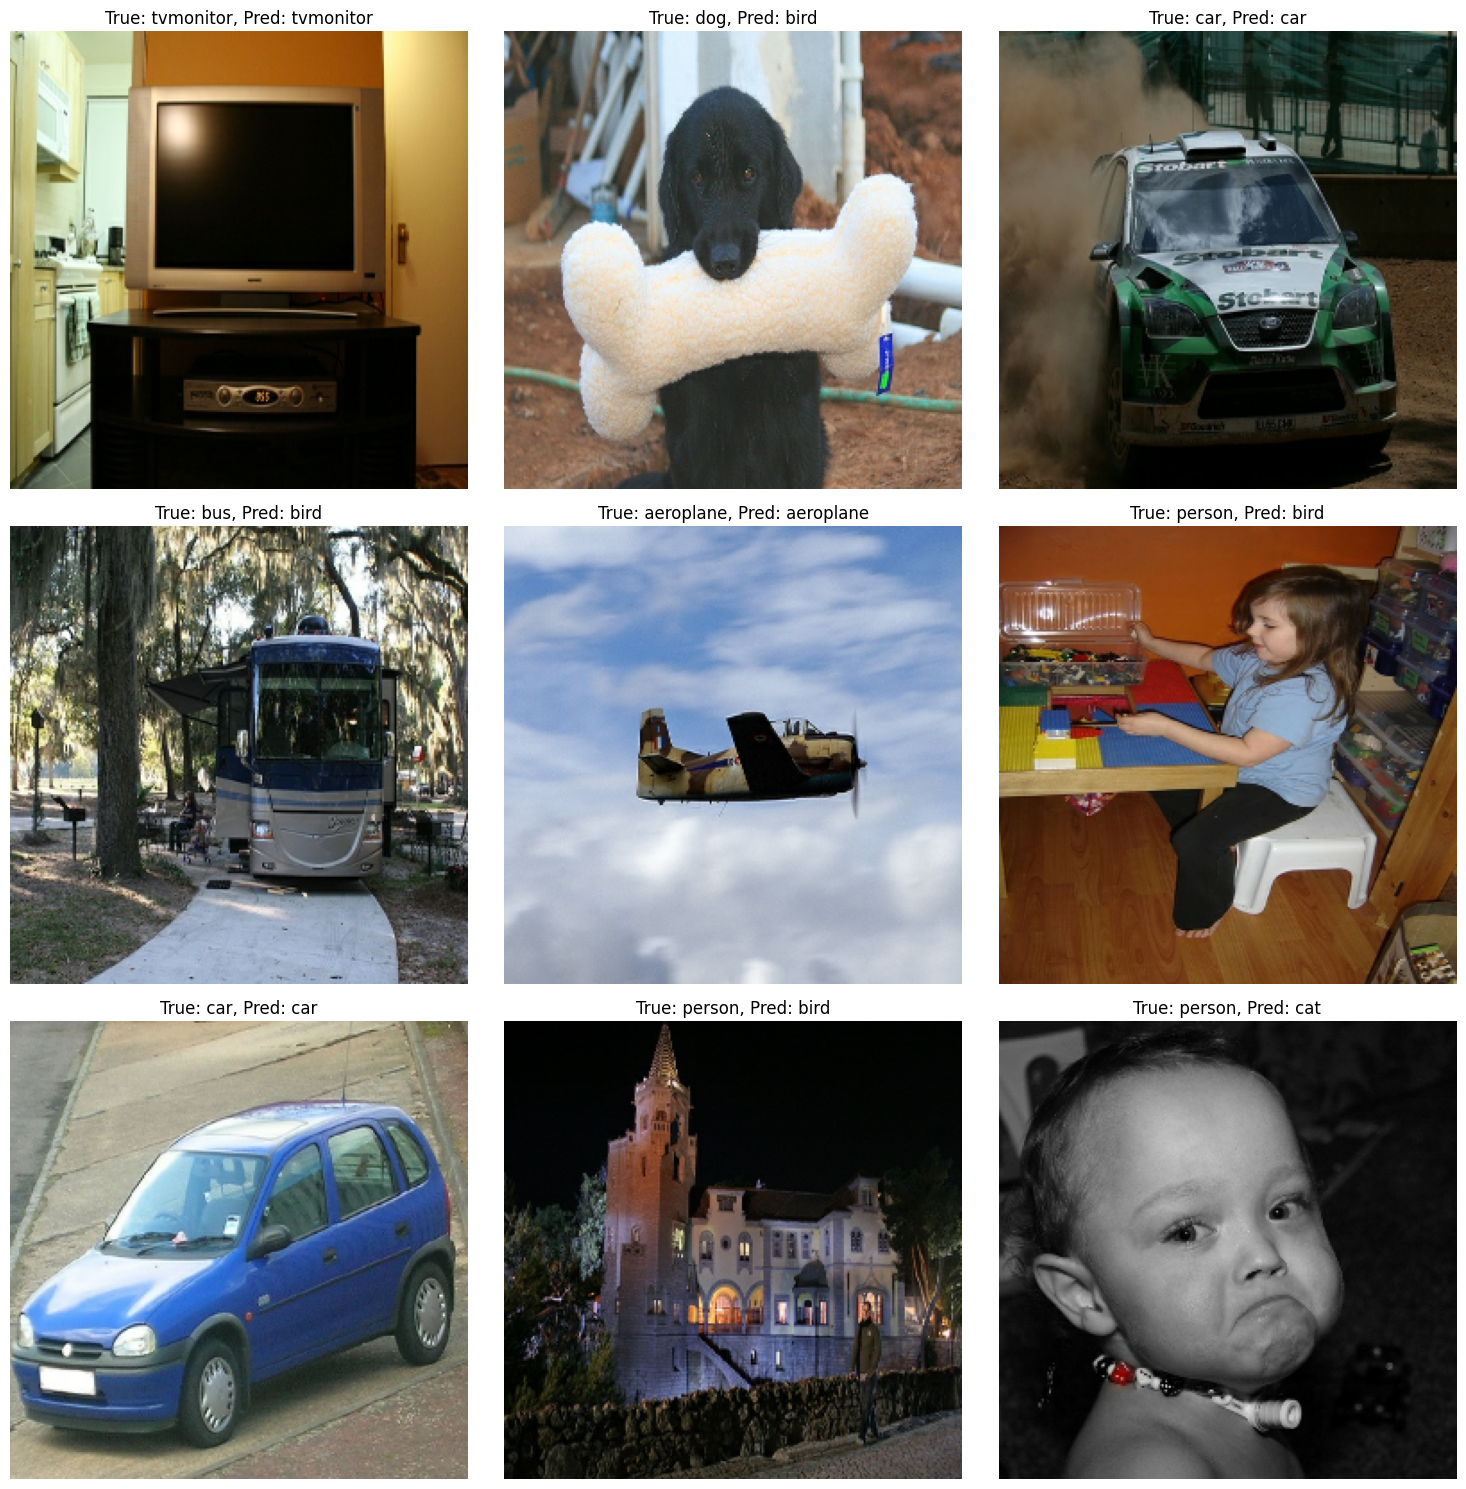

In [17]:
import numpy as np

def display_images_in_grid(images, true_labels, pred_labels, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    for img, true_lbl, pred_lbl, ax in zip(images, true_labels, pred_labels, axes):
        ax.imshow(img)
        ax.set_title(f'True: {true_lbl}, Pred: {pred_lbl}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Collect images, true labels, and predicted labels from the test dataset
images = []
true_labels = []
pred_labels = []

for image_batch, label_batch in test_dataset.take(5):
    predictions = model.predict(image_batch)
    for img, true_lbl, pred_lbl in zip(image_batch, label_batch.numpy(), tf.argmax(predictions, axis=1).numpy()):
        images.append(img.numpy())
        true_labels.append(true_lbl)
        pred_labels.append(pred_lbl)

# Convert numeric labels to class names for better readability
class_names = info.features['objects']['label'].names
true_labels = [class_names[lbl] for lbl in true_labels]
pred_labels = [class_names[lbl] for lbl in pred_labels]

# Display images in a grid
display_images_in_grid(images, true_labels, pred_labels, rows=3, cols=3)


Why the metrics are low:

**Small Dataset Impacts Accuracy**

* **Limited Exposure:** With only 800 images, your model is exposed to a limited variety of object instances, poses, backgrounds, and lighting conditions. This restricts its ability to generalize well to unseen data.
* **Overfitting:** A small dataset increases the risk of overfitting. The model might learn to memorize the training data rather than extract generalizable features. This leads to poor performance on unseen data.
* **Insufficient Data for Learning Complex Features:** Object detection models need a significant amount of data to learn complex features that distinguish between different objects and their variations. 800 images might not be enough for the model to learn these features effectively.

**Possible Solutions**

1. **Data Augmentation:** This is a key technique for small datasets. It involves creating new, synthetic variations of your existing images:
* **Rotation, Flipping, Scaling:** These augmentations introduce variations in object positions and sizes.
* **Color Jittering:** Adjust color saturation, brightness, and contrast to improve robustness.
* **Adding Noise:** Injecting small amounts of noise can make the model more resilient to real-world image variations.
* **Cropping and Padding:** Generate different views of the object.

3. **Data Synthesis:** Generate synthetic data:
* **Use 3D models:** If possible, create synthetic images of your objects from 3D models. This allows you to control various parameters and generate diverse data.

4. **Optimize Model Architecture:**
* **Simpler Architecture:** A simpler model with fewer parameters may be less prone to overfitting with a small dataset.
